In [2]:
!git clone -b mittra https://github.com/tirthankar95/CSCI_7000_FinalProject.git

Cloning into 'CSCI_7000_FinalProject'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 559 (delta 28), reused 65 (delta 20), pack-reused 477
Receiving objects: 100% (559/559), 24.75 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (233/233), done.


In [3]:
import tensorflow as tf 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
%cd /content/CSCI_7000_FinalProject/gym-minigrid/

/content/CSCI_7000_FinalProject/gym-minigrid


In [5]:
from HandCraftedEnv.mydoorkey_env import *
from HandCraftedEnv.mylava_env import *

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import LSTM,Bidirectional,Dense,Input,Embedding,TimeDistributed,SimpleRNN,Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [36]:
def plotProgress(reward_plot,xlabel,ylabel,title):
    plt.plot(reward_plot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def create():
    global num_actions,frameForPrediction
    input=Input(shape=(frameForPrediction,25)) # (4,1,5,5) ~ my grid returns (1,2*visibility+1,2*visibility+1)
    temp=LSTM(units=100,return_sequences=False)(input)
    temp=Dense(units=100, activation='relu')(temp)
    temp=Dense(units=50, activation='relu')(temp)
    temp=Dense(units=10, activation='relu')(temp)
    output=Dense(units=num_actions,activation='linear')(temp)
    model=Model(input,output)
    return model

In [37]:
def trainAgentInEnv():
  global model,model_target,loss_function,optimizer,reward_plot
  # Configuration paramaters for the whole setup
  seed = 42
  gamma = 0.99  # Discount factor for past rewards
  epsilon = 1.0  # Epsilon greedy parameter
  epsilon_min = 0.1  # Minimum epsilon greedy parameter
  epsilon_max = 1.0  # Maximum epsilon greedy parameter
  epsilon_interval = (
      epsilon_max - epsilon_min
  )  # Rate at which to reduce chance of random action being taken
  batch_size = 128  # Size of batch taken from replay buffer
  max_steps_per_episode = 1000
  # Experience replay buffers
  action_history = []
  state_history = []
  state_next_history = []
  rewards_history = []
  episode_reward_history=[]
  done_history = []

  running_reward = 0
  frame_count = 0
  # Number of frames to take random action and observe output
  epsilon_random_frames = 10000
  # Number of frames for exploration
  epsilon_greedy_frames = 1000000.0
  # Maximum replay length
  # Note: The Deepmind paper suggests 1000000 however this causes memory issues
  max_memory_length = 100000
  # Train the model after 4 actions
  update_after_actions = 10
  # How often to update the target network
  update_target_network = 10000
  # Using huber loss for stability
  # We are taking 4 frames in our LSTM
  frame_offset=frameForPrediction-1
  noOfEpisodes=1000 #beast 100000

  dummy_state=[[[-1 for i in range(5)] for j in range(5)]] #2*visibility+1=5
  dummy_action=-1
  dummy_reward=-1
  dummy=-1
  # Run this multiple times. (1000)
  state, reward, done, _ = env.reset_m()
  for _ in tqdm(range(noOfEpisodes)):  # Run until solved
      state, reward, done, _ = env.reset_prev()
      episode_reward = 0
      for i in range(frame_offset):
        state_history.append(dummy_state)
        state_next_history.append(dummy_state)
        rewards_history.append(dummy_reward)
        action_history.append(dummy_action)
        done_history.append(dummy)
      for timestep in range(1, max_steps_per_episode):
          # env.render(); Adding this line would show the attempts
          # of the agent in a pop up window.
          frame_count += 1
          # Use epsilon-greedy for exploration
          if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
              # Take random action
              action = np.random.choice(num_actions)
          else:
              # Predict action Q-values
              # From environment state
              state_numpy = np.array(state_history[-frameForPrediction:]).reshape(frameForPrediction,25)
              state_numpy = np.array([state_numpy])
              action_probs = model(state_numpy, training=False)
              # Take best action
              action = np.argmax(action_probs[0])

          # Decay probability of taking random action
          epsilon -= epsilon_interval / epsilon_greedy_frames
          epsilon = max(epsilon, epsilon_min)

          # Apply the sampled action in our environment
          state_next, reward, done, _ = env.step_m(action)
          episode_reward += reward

          # Save actions and states in replay buffer
          state_history.append(state)
          state_next_history.append(state_next)
          action_history.append(action)
          done_history.append(done)
          rewards_history.append(reward)
          state = state_next

          # Update every fourth frame and once batch size is over 32
          if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
              # Get indices of samples for replay buffers
              indices = np.random.choice(range(len(done_history)-frame_offset), size=batch_size)+frame_offset
              # Using list comprehension to sample from replay buffer
              i=indices[0]
              state_sample = np.array([ np.array(state_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              state_next_sample = np.array([ np.array(state_next_history[i-frame_offset:i+1]).reshape(frameForPrediction,25) for i in indices])
              rewards_sample = [rewards_history[i] for i in indices]
              action_sample = [action_history[i] for i in indices]
              # Build the updated Q-values for the sampled future states
              # Use the target model for stability
              future_rewards = model_target.predict(state_next_sample,verbose=False)
              # Q value = reward + discount factor * expected future reward
              updated_q_values = rewards_sample + gamma * np.max(future_rewards, axis=1)
              updated_q_values = updated_q_values.astype('float32')
              # Create a mask so we only calculate loss on the updated Q-values
              masks = tf.one_hot(action_sample, num_actions)
              with tf.GradientTape() as tape:    
                  q_values = model(state_sample)
                  # Apply the masks to the Q-values to get the Q-value for action taken
                  q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                  loss = loss_function(updated_q_values,q_action)
              # Backpropagation
              grads = tape.gradient(loss, model.trainable_variables)
              optimizer.apply_gradients(zip(grads, model.trainable_variables))
              

          if frame_count % update_target_network == 0:
              model.save('Expert_dk.ml')
              # update the the target network with new weights
              model_target.set_weights(model.get_weights())
              # Log details
              template = "running reward: {:.2f} at episode {}, frame count {}"
              print(template.format(running_reward, episode_count, frame_count))

          # Limit the state and reward history
          if len(rewards_history) > max_memory_length:
              del rewards_history[:1]
              del state_history[:1]
              del state_next_history[:1]
              del action_history[:1]
              del done_history[:1]
          if done:
              break
      # Update running reward to check condition for solving
      episode_reward_history.append(episode_reward)
      running_reward = np.mean(episode_reward_history)
      reward_plot.append(episode_reward)
      episode_steps_plot.append(timestep)

In [23]:
num_actions=5
frameForPrediction=4
reward_plot = []
episode_steps_plot = []
env = doorkey()
model=create()
model_target=create()
loss_function = keras.losses.MeanSquaredError()
optimizer=keras.optimizers.RMSprop()

 26%|██▌       | 257/1000 [01:21<14:38,  1.18s/it]

running reward: -27.79 at episode 255, frame count 10000


 53%|█████▎    | 531/1000 [02:47<09:58,  1.28s/it]

running reward: -26.70 at episode 530, frame count 20000


 85%|████████▌ | 850/1000 [04:09<00:35,  4.28it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


running reward: -24.24 at episode 851, frame count 30000


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


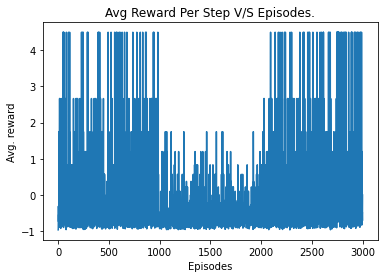

In [31]:
#Use for loop later on but for now call manually
trainAgentInEnv()
plotProgress(reward_plot,'Episodes','Total Reward','Total Reward V/S Episodes.')
plotProgress(episode_steps_plot,'Episodes','Steps','Steps Reward V/S Episodes.')
model.save('Expert_dk.ml')

In [25]:
from google.colab import drive,files
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!cp -rf Expert_dk.ml /content/drive/MyDrive/SavedRLModels/

In [34]:
state, reward, done, _ = env.reset_prev()
frame_offset=frameForPrediction-1

state_historyP=[ state for i in range(frameForPrediction)]

while not done:
  state_numpyP = np.array(state_historyP[-frameForPrediction:]).reshape(frameForPrediction,25)
  state_numpyP = np.array([state_numpyP])
  action_probs = model(state_numpyP, training=False)
  action = np.argmax(action_probs[0])
  env.printEnv()
  print(action)
  state, reward, done, _ = env.step_m(action)
  del state_historyP[:1]
  state_historyP.append(state)



4 0 0 0 
0 0 0 0 
2 0 0 0 
0 1 0 0 



3


0 0 0 0 
5 0 0 0 
2 0 0 0 
0 1 0 0 



3
